In [1]:
import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_dir = '../'
data_dir = base_dir + 'data/'
model_dir = base_dir + 'models/'

In [3]:
good_img_dir = data_dir + 'img_good/'
bad_img_dir = data_dir + 'img_bad/'
validation_dir = data_dir + 'validation/'

good_img_paths = glob.glob(good_img_dir+'*.jpeg')
bad_img_paths = glob.glob(bad_img_dir+'*.jpeg')

print(good_img_dir, ':', len(good_img_paths))
print(bad_img_dir, ':', len(bad_img_paths))

../data/img_good/ : 352
../data/img_bad/ : 247


In [4]:
# Standard image size
I_WIDTH,I_HEIGHT = Image.open(good_img_paths[9]).size
I_WIDTH,I_HEIGHT

(1080, 2336)

In [5]:
import random

#Pixel coordinates for the crop, Left,Top,Right,Bottom 
STD_CROP_LTRB = (0, 650, I_WIDTH, I_HEIGHT-750)
STD_SHAPE = (256, 256)
def crop_to_std_size(img):
    """Crop the image to a standard size"""
    return img.crop(STD_CROP_LTRB)

def reshape_to_std_size(img):
    """Reshape the image to a standard size"""
    return img.resize(STD_SHAPE)

def augment_image(img):
    """Randomly apply some augmentation"""
    r = random.randint(0, 5) # Choose between 0,1,2,3,4
    if r == 0:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    elif r == 1:
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    elif r == 2:
        return img.transpose(Image.ROTATE_90)
    elif r == 3:
        return img.transpose(Image.ROTATE_180)
    else:
        return img.transpose(Image.ROTATE_270)
    
def transform_image(img_path, augment=False):
    """Transforms and converts the image to numpy array
    img_path: Image to be loaded and processed
    augment: Whether to apply image augmentation or not
    """
    img = Image.open(img_path)
    img = crop_to_std_size(img)
    img = reshape_to_std_size(img)
    #Only if image augmentation is needed
    if augment:
        img = augment_image(img)
            
    # TODO Other operations
    return np.array(img)

def transform_images(img_paths, augment=False, increase_samples=False):
    """Loads, processes and converts list of image paths into numpy array of numpy-images
    img_paths: List of image paths
    augment: Whether to apply random image augmentations
    increase_samples: Whether to randomly create new images after augmentation or not. Requires 'augment'=True.
    """
    print('Augment enabled:', augment)
    all_images = []
    for img_path in img_paths:
        # TODO
        # If augment==True, then randomly call transform_image again with augment=True
        np_img = transform_image(img_path, augment)
        all_images.append(np_img)
        
        # If increase_samples==True, then randomly add the original image as well to the list
        if augment and increase_samples:
            # Add original or not?
            add_original = random.randint(0,2) # Choose between 0,1
            if add_original == 0:
                np_img = transform_image(img_path, augment=False) #No augmentation
                all_images.append(np_img)
        
    #Convert list to numpy
    return np.array(all_images)

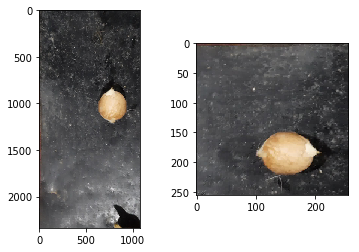

In [6]:
#Trial and Error
#sample_path = good_img_paths[20]
sample_path = bad_img_paths[90]
sample_img = Image.open(sample_path)
fg = plt.figure()
fg.add_subplot(1,2,1)
plt.imshow(sample_img)
trans_img = transform_image(sample_path, augment=True)
fg.add_subplot(1,2,2)
plt.imshow(trans_img)

In [7]:
np_good = transform_images(good_img_paths, augment=True)
np_bad = transform_images(bad_img_paths, augment=True, increase_samples=True) # To increase the bad examples
print('Good np images:', np_good.shape)
print('Bad np images:', np_bad.shape)

Augment enabled: True
Augment enabled: True
Good np images: (352, 256, 256, 3)
Bad np images: (331, 256, 256, 3)


In [8]:
print('Added {} extra images for Good'.format(np_good.shape[0] - len(good_img_paths)))
print('Added {} extra images for Bad'.format(np_bad.shape[0] - len(bad_img_paths)))

Added 0 extra images for Good
Added 84 extra images for Bad


In [7]:
# target labels
GOOD = 0
BAD = 1

In [9]:
# target data
np_good_y = np.full((np_good.shape[0], 1), GOOD)
np_bad_y = np.full((np_bad.shape[0], 1), BAD)
(np_good_y.shape, np_bad_y.shape)

((352, 1), (331, 1))

In [10]:
# Combine all the examples
all_x = np.concatenate((np_good, np_bad), axis=0)
all_y = np.concatenate((np_good_y, np_bad_y), axis=0)
(all_x.shape, all_y.shape)

((683, 256, 256, 3), (683, 1))

In [11]:
from keras.utils import to_categorical
#one-hot encode target column
all_y = to_categorical(all_y)
all_y

Using TensorFlow backend.
/home/jupyter-admin/KERAS_VENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter-admin/KERAS_VENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter-admin/KERAS_VENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter-admin/KERAS_VENV/l

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [12]:
np.unique(all_y, return_counts=True, axis=0)

(array([[0., 1.],
        [1., 0.]], dtype=float32), array([331, 352]))

In [13]:
from sklearn.model_selection import train_test_split
# Train & Test split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.1, random_state=42)
print('Train X:', x_train.shape)
print('Test X:', x_test.shape)
print('Train Y:', y_train.shape)
print('Test Y:', y_test.shape)

Train X: (614, 256, 256, 3)
Test X: (69, 256, 256, 3)
Train Y: (614, 2)
Test Y: (69, 2)


In [10]:
STD_WIDTH,STD_HEIGHT = STD_SHAPE
INPUT_SHAPE = (STD_WIDTH, STD_HEIGHT, 3)

In [19]:
# Keras CNN Model
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))
   
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy'])

In [20]:
# Train the model
EPOCHS = 20
BATCH_SIZE = 20
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Train on 614 samples, validate on 69 samples
Epoch 1/20
614/614 [==============================] - 40s 65ms/step - loss: 93.0644 - binary_accuracy: 0.5130 - val_loss: 0.6862 - val_binary_accuracy: 0.4058
Epoch 2/20
614/614 [==============================] - 39s 64ms/step - loss: 0.4836 - binary_accuracy: 0.7704 - val_loss: 0.6463 - val_binary_accuracy: 0.5072
Epoch 3/20
614/614 [==============================] - 39s 63ms/step - loss: 0.3593 - binary_accuracy: 0.8518 - val_loss: 0.5433 - val_binary_accuracy: 0.8696
Epoch 4/20
614/614 [==============================] - 39s 63ms/step - loss: 0.1997 - binary_accuracy: 0.9039 - val_loss: 0.4076 - val_binary_accuracy: 0.9275
Epoch 5/20
614/614 [==============================] - 40s 64ms/step - loss: 0.1258 - binary_accuracy: 0.9495 - val_loss: 0.3953 - val_binary_accuracy: 0.9275
Epoch 6/20
614/614 [==============================] - 39s 64ms/step - loss: 0.0938 - binary_accuracy: 0.9658 - val_loss: 0.3398 - val_binary_accuracy: 0.8986
Epoch 

In [21]:
# Save the model
import time
timestamp = time.strftime('%Y%m%d_%H%M')
model.save(model_dir+'model_'+timestamp)
print('Saved the model at:', (model_dir+'model_'+timestamp))

Saved the model at: ../models/model_20201126_1448


In [8]:
# Optionally load the model
from tensorflow import keras

base_dir = '/home/adiga/my_work/arecanut-images/'
model_dir = base_dir + 'areca_classifier/model/'
model = keras.models.load_model(model_dir+'model_20201126_1448')

In [9]:
validation_dir = base_dir + 'test/debug_imgs/'

In [12]:
valid_image_paths = glob.glob(validation_dir+'/*frame_BAD.png')
len(valid_image_paths)

69

In [16]:
# Standard image size
I_WIDTH,I_HEIGHT = Image.open(valid_image_paths[45]).size
I_WIDTH,I_HEIGHT

(1080, 1920)

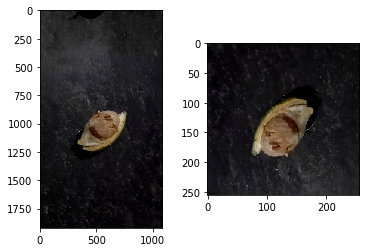

In [17]:
#Trial and Error
sample_path = valid_image_paths[50]
sample_img = Image.open(sample_path)
fg = plt.figure()
fg.add_subplot(1,2,1)
plt.imshow(sample_img)
trans_img = transform_image(sample_path, augment=True)
fg.add_subplot(1,2,2)
plt.imshow(trans_img)

In [18]:
import time
# Prediction
start = time.time()
np_input = transform_images(valid_image_paths)
predictions = model.predict(np_input)
end = time.time()
seconds_taken = (end - start)
print('Took {} seconds to predict {} images'.format(seconds_taken, len(valid_image_paths)))
# Convert probability to classes
predictions = np.argmax(predictions, axis=1)

Augment enabled: False
Took 5.862343788146973 seconds to predict 69 images


In [19]:
class_dict = {GOOD: 'good', BAD: 'bad'}
pred_classes = [class_dict[p] for p in predictions]
pred_classes

['bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad',
 'bad']

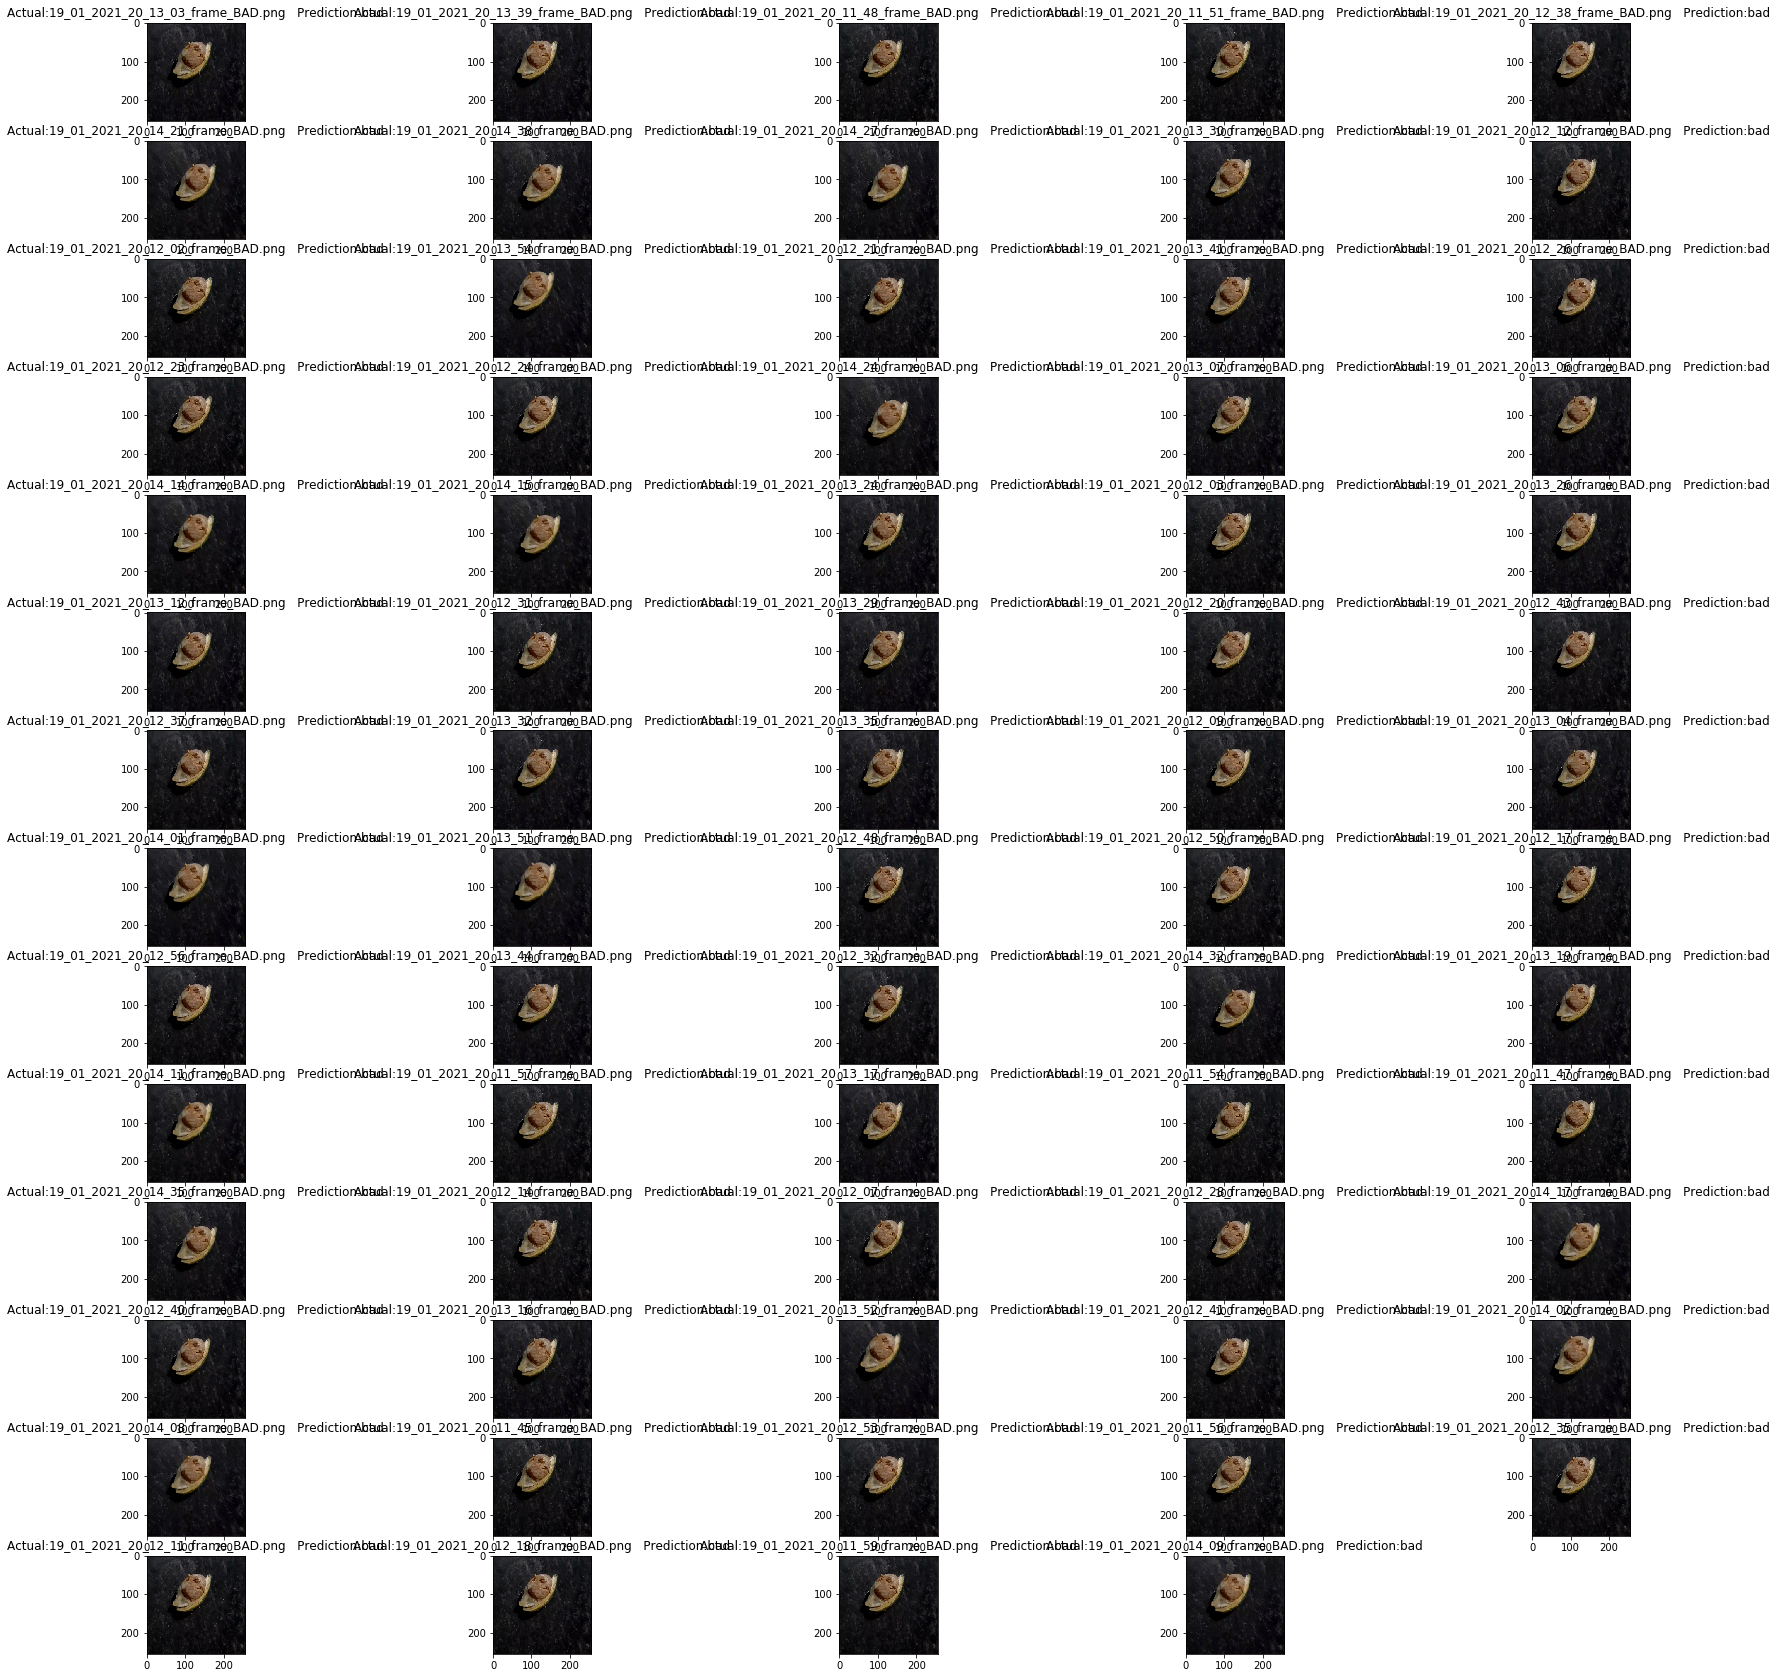

In [24]:
fg = plt.figure(figsize=(30,30))
for i,fp in enumerate(valid_image_paths):
    fg.add_subplot(14,5,i+1)
    plt.imshow(np_input[i])
    title='Actual:' + fp.split('/')[-1].split('-')[0] + '   Prediction:' + str(pred_classes[i])
    plt.title(title)